# 0. Extra Config as my pc has multiple JVMs 

In [1]:
!/usr/libexec/java_home -V

Matching Java Virtual Machines (8):
    23 (arm64) "Eclipse Adoptium" - "OpenJDK 23" /Library/Java/JavaVirtualMachines/temurin-23.jdk/Contents/Home
    19.0.2 (arm64) "Amazon.com Inc." - "Amazon Corretto 19" /Users/him/Library/Java/JavaVirtualMachines/corretto-19.0.2/Contents/Home
    17.0.8 (arm64) "Oracle Corporation" - "Java SE 17.0.8" /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
    11.0.23 (arm64) "Amazon.com Inc." - "Amazon Corretto 11" /Users/him/Library/Java/JavaVirtualMachines/corretto-11.0.23/Contents/Home
    11.0.22 (arm64) "Eclipse Adoptium" - "OpenJDK 11.0.22" /Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home
    1.8.431.10 (x86_64) "Oracle Corporation" - "Java" /Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home
    1.8.0_412 (arm64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMachines/corretto-1.8.0_412/Contents/Home
    1.8.0_412 (x86_64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMach

In [1]:
import os

In [2]:
java_path = "/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home"
java_home = os.environ.get('JAVA_HOME', None)

print("Existing Java Home: ",java_home)

if (not java_home) or (java_path not in java_home):
    os.environ['JAVA_HOME'] = java_path

print("Updated Java Home: ",os.environ.get('JAVA_HOME', None))

Existing Java Home:  None
Updated Java Home:  /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home


In [3]:
# print java version

os.system('java -version')

java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


0

# 1. Load data

In [ ]:
import pandas as pd

In [6]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 2. Prepocessing

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

In [7]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [8]:
spark = SparkSession\
        .builder\
        .appName("combined")\
        .getOrCreate()


24/11/28 18:09:24 WARN Utils: Your hostname, Yuen-Man-Hims-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.89.166.58 instead (on interface en0)
24/11/28 18:09:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/28 18:09:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
data = spark.createDataFrame(train_df)
train, valid = data.randomSplit([0.35, 0.65], seed=12345)

assembler = VectorAssembler(
    inputCols = train_df.columns[1:].to_list(),
    outputCol = "features")
train = assembler.transform(train)
valid = assembler.transform(valid)
y_true = valid.select('Survived').toPandas()

# 3. Model

In [ ]:
from sklearn.metrics import f1_score

## 3.1 Naive-bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
# create the trainer and set its parameters
nb = NaiveBayes(
    smoothing=1.0, 
    modelType="complement", 
    labelCol="Survived"
    )

# train the model
nbModel = nb.fit(train)

# select example rows to display.
nbResult = nbModel.transform(valid)

24/11/28 18:09:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/28 18:09:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [11]:
nbResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|         probability|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|       0|     1|  1|             19.0|    3|    2|  263.0|       0|[1.0,1.0,19.0,3.0...|[-102.90479354434...|[2.03711713726180...|       1.0|
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[-0.1374212834842...|[0.87160295684474...|       0.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[-0.0021174196878...|[0.99788482046380...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[-2.7403122235727...|[0.06455018965571...|       1.0|

In [12]:
nb_y_pred = nbResult.select('prediction').toPandas().values
nb_f1 = f1_score(y_true, nb_y_pred)

## 3.2 Linear Support Vector Machine (LinearSVM)

In [ ]:
from pyspark.ml.classification import LinearSVC

In [ ]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="Survived", featuresCol="features")

# Fit the model
lsvcModel = lsvc.fit(train)

lsvcResult = lsvcModel.transform(valid)

In [14]:
lsvcResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+----------+
|       0|     1|  1|             19.0|    3|    2|  263.0|       0|[1.0,1.0,19.0,3.0...|[1.11859142297071...|       0.0|
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[0.88578780970810...|       0.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[0.89721772738040...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[1.06649657993054...|       0.0|
|       0|     1|  1|             47.0|    0|    0|   52.0|       0|[1.0,1.0,47.0,0.0...|[0.94127411707960...|       0.0|
|       0|     1|  1|   

In [15]:
lsvc_y_pred = lsvcResult.select('prediction').toPandas().values
lsvc_f1 = f1_score(y_true, lsvc_y_pred)

## 3.3 Multilayer Perceptron (MLP)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
trainer = MultilayerPerceptronClassifier(
    labelCol="Survived",
    featuresCol="features",
    maxIter=1500, 
    layers=[len(assembler.getInputCols()), 4, 2], 
    blockSize=128, 
    seed=1234
    )

# train the model
mlpModel = trainer.fit(train)

# compute accuracy on the test set
mlpResult = mlpModel.transform(valid)

In [17]:
mlpResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|         probability|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|       0|     1|  1|             19.0|    3|    2|  263.0|       0|[1.0,1.0,19.0,3.0...|[0.33219551564158...|[0.72767999677926...|       0.0|
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[0.33219802082379...|[0.72768097704230...|       0.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[0.33219601623760...|[0.72768020779275...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[0.33222122790630...|[0.72768988259470...|       0.0|

In [18]:
mlp_y_pred = mlpResult.select('prediction').toPandas().values
mlp_f1 = f1_score(y_true, mlp_y_pred)

# 4 Ensemble

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

## 4.1 Ensemble of 3 models (Naive-bayes, LinearSVM, MLP)

In [ ]:
f1_total = nb_f1 + lsvc_f1 + mlp_f1
y_pred = np.round((nb_y_pred * nb_f1 + lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total)

# Create accuracy score
print("accuracy: ", accuracy_score(y_true, y_pred))

# Create classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Result is not that good enough, lets try with 2 models before tuning

## 4.2 Ensemble of 2 models (LinearSVM, MLP)

In [ ]:
f1_total = lsvc_f1 + mlp_f1
y_pred = np.round((lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total)

# Create accuracy score
print("accuracy: ", accuracy_score(y_true, y_pred))

# Create classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 5. Stop the spark

In [22]:
spark.stop()

# 6. Hyperparameter tuning

By some chance, I found that the model is very predictive/overfit (I am not sure to be honest) that lowering the portion of the training data will increase the accuracy. So, I will try to tune the hyperparameter of the model to see if it can be improved.

In [4]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes, LinearSVC, MultilayerPerceptronClassifier
from sklearn.metrics import f1_score, accuracy_score

In [6]:
metrics_map = []
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [ ]:
split_ratio = [[0.9, 0.1], [0.85, 0.15], [0.8, 0.2], [0.75, 0.25], [0.7, 0.3], [0.65, 0.35], [0.6, 0.4], [0.55, 0.45], [0.5, 0.5], [0.45, 0.55], [0.4, 0.6], [0.35, 0.65], [0.3, 0.7], [0.25, 0.75], [0.2, 0.8], [0.15, 0.85], [0.1, 0.9]]
for ratio in split_ratio:
    metric = {}
    metric["ratio"] = ratio
    appName = "conbined_" + str(ratio[0]) + str(ratio[1])
    spark = SparkSession.builder.appName(name=appName).getOrCreate()
    
    data = spark.createDataFrame(train_df)
    assembler = VectorAssembler(inputCols = train_df.columns[1:].to_list(), outputCol = "features")
    data = assembler.transform(data)
    train, valid = data.randomSplit(ratio, seed=12345)
    y_true = valid.select('Survived').toPandas()
    y_true.to_csv(f'result/ensemble/y_true_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', index=False)
    
    
    nb = NaiveBayes(smoothing=1.0, modelType="complement", labelCol="Survived")
    nbModel = nb.fit(train)
    nbResult = nbModel.transform(valid)
    nb_y_pred = nbResult.select('prediction').toPandas().values
    np.savetxt(f'result/ensemble/nb_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', nb_y_pred, delimiter=",")
    nb_f1 = f1_score(y_true, nb_y_pred)
    metric['nb'] = nb_f1
    
    lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="Survived", featuresCol="features")
    lsvcModel = lsvc.fit(train)
    lsvcResult = lsvcModel.transform(valid)
    lsvc_y_pred = lsvcResult.select('prediction').toPandas().values
    np.savetxt(f'result/ensemble/lsvc_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', lsvc_y_pred, delimiter=",")
    lsvc_f1 = f1_score(y_true, lsvc_y_pred)
    metric['lsvc'] = lsvc_f1
    
    trainer = MultilayerPerceptronClassifier(labelCol="Survived", featuresCol="features", maxIter=1500, 
                                             layers=[len(assembler.getInputCols()), 4, 2], blockSize=128, seed=1234)
    mlpModel = trainer.fit(train)
    mlpResult = mlpModel.transform(valid)
    mlp_y_pred = mlpResult.select('prediction').toPandas().values
    np.savetxt(f'result/ensemble/mlp_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', mlp_y_pred, delimiter=",")
    mlp_f1 = f1_score(y_true, mlp_y_pred)
    metric['mlp'] = mlp_f1
    
    f1_total_3 = nb_f1 + lsvc_f1 + mlp_f1
    y_pred_3 = np.round((nb_y_pred * nb_f1 + lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total_3)
    np.savetxt(f'result/ensemble/y_pred_3_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', y_pred_3, delimiter=",")

    acc_3 = accuracy_score(y_true, y_pred_3)
    metric['acc_3'] = acc_3
    
    f1_total_2 = lsvc_f1 + mlp_f1
    y_pred_2 = np.round((lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total_2)
    np.savetxt(f'result/ensemble/y_pred_2_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', y_pred_2, delimiter=",")

    acc_2 = accuracy_score(y_true, y_pred_2)
    metric['acc_2'] = acc_2
    
    metrics_map.append(metric)
    
    spark.stop()

metrics_df = pd.DataFrame(metrics_map)
metrics_df.to_csv('result/ensemble/metrics.csv', index=False)

24/11/28 22:27:11 WARN Utils: Your hostname, Yuen-Man-Hims-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.31 instead (on interface en0)
24/11/28 22:27:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/28 22:27:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/28 22:27:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/28 22:27:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/28 22:27:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/28 22:28:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/28 22:29:32 ERROR StrongWolfeLineSearch: Encounter

In [7]:
spark = SparkSession.builder.appName(name="assembler").getOrCreate()
    
data = spark.createDataFrame(train_df)
assembler = VectorAssembler(inputCols = train_df.columns[1:].to_list(), outputCol = "features")
data = assembler.transform(data)

print(len(assembler.getInputCols()))

7


In [9]:
split_ratio = [[0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7]]
maxIters = [100, 500, 1000, 1500, 1800]
layers = [[len(assembler.getInputCols()), 4, 2], [len(assembler.getInputCols()), 32, 64, 16, 2]]
blockSizes = [16, 64, 128, 256]
for ratio in split_ratio:
    metrics_map = []
    for iter in maxIters:
        for layer in layers:
            for blkSize in blockSizes:
                metric = {}
                metric["maxIter"] = iter
                metric["layer"] = layer
                metric["blockSize"] = blkSize
                appName = "conbined_" + str(ratio[0]) + str(ratio[1]) + '_' + str(iter) + '_' + str(layer[1]) + '_' + str(blkSize)
                spark = SparkSession.builder.appName(name=appName).getOrCreate()
    
                data = spark.createDataFrame(train_df)
                assembler = VectorAssembler(inputCols = train_df.columns[1:].to_list(), outputCol = "features")
                data = assembler.transform(data)
                train, valid = data.randomSplit(ratio, seed=12345)
                y_true = valid.select('Survived').toPandas()
                y_true.to_csv(f'result/ensemble/y_true_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', index=False)
                
                
                nb = NaiveBayes(smoothing=1.0, modelType="complement", labelCol="Survived")
                nbModel = nb.fit(train)
                nbResult = nbModel.transform(valid)
                nb_y_pred = nbResult.select('prediction').toPandas().values
                np.savetxt(f'result/ensemble/nb_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', nb_y_pred, delimiter=",")
                nb_f1 = f1_score(y_true, nb_y_pred)
                metric['nb'] = nb_f1
                
                lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="Survived", featuresCol="features")
                lsvcModel = lsvc.fit(train)
                lsvcResult = lsvcModel.transform(valid)
                lsvc_y_pred = lsvcResult.select('prediction').toPandas().values
                np.savetxt(f'result/ensemble/lsvc_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', lsvc_y_pred, delimiter=",")
                lsvc_f1 = f1_score(y_true, lsvc_y_pred)
                metric['lsvc'] = lsvc_f1
                
                trainer = MultilayerPerceptronClassifier(labelCol="Survived", featuresCol="features", maxIter=iter, 
                                                        layers=layer, blockSize=blkSize, seed=1234)
                mlpModel = trainer.fit(train)
                mlpResult = mlpModel.transform(valid)
                mlp_y_pred = mlpResult.select('prediction').toPandas().values
                np.savetxt(f'result/ensemble/mlp_y_pred_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', mlp_y_pred, delimiter=",")
                mlp_f1 = f1_score(y_true, mlp_y_pred)
                metric['mlp'] = mlp_f1
                
                f1_total_3 = nb_f1 + lsvc_f1 + mlp_f1
                y_pred_3 = np.round((nb_y_pred * nb_f1 + lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total_3)
                np.savetxt(f'result/ensemble/y_pred_3_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', y_pred_3, delimiter=",")

                acc_3 = accuracy_score(y_true, y_pred_3)
                metric['acc_3'] = acc_3
                
                f1_total_2 = lsvc_f1 + mlp_f1
                y_pred_2 = np.round((lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total_2)
                np.savetxt(f'result/ensemble/y_pred_2_{int(ratio[0] * 100)}{int(ratio[1] * 100)}_{iter}_{layer[1]}_{blkSize}.csv', y_pred_2, delimiter=",")

                acc_2 = accuracy_score(y_true, y_pred_2)
                metric['acc_2'] = acc_2
                
                metrics_map.append(metric)
                
                spark.stop()

    metrics_df = pd.DataFrame(metrics_map)
    metrics_df.to_csv(f'result/ensemble/metrics_{int(ratio[0] * 100)}{int(ratio[1] * 100)}.csv', index=False)

24/11/29 09:11:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/29 09:11:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/29 09:12:11 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 09:13:46 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 09:13:46 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 09:13:46 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/11/29 09:13:46 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
24/11/29 09:13:46 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/11/29 09:26:34 ERROR StrongWolfeLineSearch: E

In [8]:
spark.stop()

# Evaluation

In [ ]:
result_map = pd.read_csv('result/ensemble/metrics.csv')
result_map

,ratio,nb,lsvc,mlp,acc_3,acc_2
0,"[0.9, 0.1]",0.428571,0.542857,0.539683,0.680851,0.659574
1,"[0.85, 0.15]",0.384615,0.580645,0.575000,0.715385,0.700000
2,"[0.8, 0.2]",0.457143,0.608000,0.649123,0.748503,0.760479
3,"[0.75, 0.25]",0.500000,0.636364,0.694444,0.766990,0.786408
4,"[0.7, 0.3]",0.533333,0.646766,0.705263,0.766284,0.785441
5,"[0.65, 0.35]",0.509804,0.672414,0.709402,0.771242,0.777778
6,"[0.6, 0.4]",0.534483,0.666667,0.731518,0.800000,0.802857
7,"[0.55, 0.45]",0.544061,0.673540,0.731034,0.796482,0.804020
8,"[0.5, 0.5]",0.569492,0.693498,0.708861,0.795506,0.793258
9,"[0.45, 0.55]",0.554517,0.708934,0.737143,0.829569,0.811088


In [18]:
result_map_7030 = pd.read_csv('result/ensemble/metrics_7030.csv')
result_map_6040 = pd.read_csv('result/ensemble/metrics_6040.csv')
result_map_5050 = pd.read_csv('result/ensemble/metrics_5050.csv')
result_map_4060 = pd.read_csv('result/ensemble/metrics_4060.csv')
result_map_3070 = pd.read_csv('result/ensemble/metrics_3070.csv')
result_map_7030['ratio'] = '7030'
result_map_6040['ratio'] = '6040'
result_map_5050['ratio'] = '5050'
result_map_4060['ratio'] = '4060'
result_map_3070['ratio'] = '3070'
result_map = pd.concat([result_map_7030, result_map_6040, result_map_5050, result_map_4060, result_map_3070], ignore_index=True)
top_acc_map_7030_2 = result_map_7030.sort_values('acc_2', ascending=False)
top_acc_map_6040_2 = result_map_6040.sort_values('acc_2', ascending=False)
top_acc_map_5050_2 = result_map_5050.sort_values('acc_2', ascending=False)
top_acc_map_4060_2 = result_map_4060.sort_values('acc_2', ascending=False)
top_acc_map_3070_2 = result_map_3070.sort_values('acc_2', ascending=False)
top_acc_map_2 = result_map.sort_values('acc_2', ascending=False)
top_acc_map_7030_3 = result_map_7030.sort_values('acc_3', ascending=False)
top_acc_map_6040_3 = result_map_6040.sort_values('acc_3', ascending=False)
top_acc_map_5050_3 = result_map_5050.sort_values('acc_3', ascending=False)
top_acc_map_4060_3 = result_map_4060.sort_values('acc_3', ascending=False)
top_acc_map_3070_3 = result_map_3070.sort_values('acc_3', ascending=False)
top_acc_map_3 = result_map.sort_values('acc_3', ascending=False)

In [19]:
top_acc_map_7030_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
15,500,"[7, 32, 64, 16, 2]",256,0.533333,0.646766,0.746114,0.789272,0.812261,7030
14,500,"[7, 32, 64, 16, 2]",128,0.533333,0.646766,0.746114,0.789272,0.812261,7030
27,1500,"[7, 4, 2]",256,0.533333,0.646766,0.705263,0.766284,0.785441,7030
26,1500,"[7, 4, 2]",128,0.533333,0.646766,0.705263,0.766284,0.785441,7030
20,1000,"[7, 32, 64, 16, 2]",16,0.533333,0.646766,0.710660,0.770115,0.781609,7030


In [20]:
top_acc_map_6040_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
39,1800,"[7, 32, 64, 16, 2]",256,0.534483,0.666667,0.731518,0.794286,0.802857,6040
34,1800,"[7, 4, 2]",128,0.534483,0.666667,0.731518,0.800000,0.802857,6040
19,1000,"[7, 4, 2]",256,0.534483,0.666667,0.731518,0.800000,0.802857,6040
18,1000,"[7, 4, 2]",128,0.534483,0.666667,0.731518,0.800000,0.802857,6040
38,1800,"[7, 32, 64, 16, 2]",128,0.534483,0.666667,0.731518,0.794286,0.802857,6040


In [21]:
top_acc_map_5050_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
6,100,"[7, 32, 64, 16, 2]",128,0.569492,0.693498,0.735484,0.806742,0.815730,5050
7,100,"[7, 32, 64, 16, 2]",256,0.569492,0.693498,0.735484,0.806742,0.815730,5050
37,1800,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.747774,0.817978,0.808989,5050
29,1500,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.737160,0.820225,0.804494,5050
21,1000,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.734940,0.813483,0.802247,5050


In [22]:
top_acc_map_4060_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
27,1500,"[7, 4, 2]",256,0.543909,0.704663,0.727273,0.813084,0.820561,4060
26,1500,"[7, 4, 2]",128,0.543909,0.704663,0.727273,0.813084,0.820561,4060
25,1500,"[7, 4, 2]",64,0.543909,0.704663,0.727273,0.813084,0.820561,4060
35,1800,"[7, 4, 2]",256,0.543909,0.704663,0.717949,0.805607,0.814953,4060
34,1800,"[7, 4, 2]",128,0.543909,0.704663,0.717949,0.805607,0.814953,4060


In [23]:
top_acc_map_3070_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
5,100,"[7, 32, 64, 16, 2]",64,0.546798,0.693694,0.731501,0.790735,0.797125,3070
6,100,"[7, 32, 64, 16, 2]",128,0.546798,0.693694,0.731501,0.790735,0.797125,3070
7,100,"[7, 32, 64, 16, 2]",256,0.546798,0.693694,0.731501,0.790735,0.797125,3070
19,1000,"[7, 4, 2]",256,0.546798,0.693694,0.668246,0.771565,0.782748,3070
16,1000,"[7, 4, 2]",16,0.546798,0.693694,0.692580,0.774760,0.782748,3070


In [24]:
top_acc_map_2.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
145,1500,"[7, 4, 2]",64,0.543909,0.704663,0.727273,0.813084,0.820561,4060
147,1500,"[7, 4, 2]",256,0.543909,0.704663,0.727273,0.813084,0.820561,4060
146,1500,"[7, 4, 2]",128,0.543909,0.704663,0.727273,0.813084,0.820561,4060
87,100,"[7, 32, 64, 16, 2]",256,0.569492,0.693498,0.735484,0.806742,0.815730,5050
86,100,"[7, 32, 64, 16, 2]",128,0.569492,0.693498,0.735484,0.806742,0.815730,5050


In [25]:
top_acc_map_7030_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
14,500,"[7, 32, 64, 16, 2]",128,0.533333,0.646766,0.746114,0.789272,0.812261,7030
15,500,"[7, 32, 64, 16, 2]",256,0.533333,0.646766,0.746114,0.789272,0.812261,7030
20,1000,"[7, 32, 64, 16, 2]",16,0.533333,0.646766,0.710660,0.770115,0.781609,7030
36,1800,"[7, 32, 64, 16, 2]",16,0.533333,0.646766,0.673684,0.766284,0.762452,7030
28,1500,"[7, 32, 64, 16, 2]",16,0.533333,0.646766,0.677083,0.766284,0.762452,7030


In [26]:
top_acc_map_6040_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
18,1000,"[7, 4, 2]",128,0.534483,0.666667,0.731518,0.8,0.802857,6040
35,1800,"[7, 4, 2]",256,0.534483,0.666667,0.731518,0.8,0.802857,6040
34,1800,"[7, 4, 2]",128,0.534483,0.666667,0.731518,0.8,0.802857,6040
27,1500,"[7, 4, 2]",256,0.534483,0.666667,0.731518,0.8,0.802857,6040
26,1500,"[7, 4, 2]",128,0.534483,0.666667,0.731518,0.8,0.802857,6040


In [27]:
top_acc_map_5050_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
29,1500,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.737160,0.820225,0.804494,5050
37,1800,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.747774,0.817978,0.808989,5050
21,1000,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.734940,0.813483,0.802247,5050
13,500,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.730539,0.813483,0.797753,5050
6,100,"[7, 32, 64, 16, 2]",128,0.569492,0.693498,0.735484,0.806742,0.815730,5050


In [28]:
top_acc_map_4060_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
27,1500,"[7, 4, 2]",256,0.543909,0.704663,0.727273,0.813084,0.820561,4060
26,1500,"[7, 4, 2]",128,0.543909,0.704663,0.727273,0.813084,0.820561,4060
25,1500,"[7, 4, 2]",64,0.543909,0.704663,0.727273,0.813084,0.820561,4060
12,500,"[7, 32, 64, 16, 2]",16,0.543909,0.704663,0.730479,0.807477,0.800000,4060
35,1800,"[7, 4, 2]",256,0.543909,0.704663,0.717949,0.805607,0.814953,4060


In [29]:
top_acc_map_3070_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
20,1000,"[7, 32, 64, 16, 2]",16,0.546798,0.693694,0.701826,0.795527,0.765176,3070
15,500,"[7, 32, 64, 16, 2]",256,0.546798,0.693694,0.697778,0.795527,0.782748,3070
14,500,"[7, 32, 64, 16, 2]",128,0.546798,0.693694,0.697778,0.795527,0.782748,3070
13,500,"[7, 32, 64, 16, 2]",64,0.546798,0.693694,0.697778,0.795527,0.782748,3070
12,500,"[7, 32, 64, 16, 2]",16,0.546798,0.693694,0.711864,0.792332,0.782748,3070


In [30]:
top_acc_map_3.head()

,maxIter,layer,blockSize,nb,lsvc,mlp,acc_3,acc_2,ratio
109,1500,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.737160,0.820225,0.804494,5050
117,1800,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.747774,0.817978,0.808989,5050
101,1000,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.734940,0.813483,0.802247,5050
93,500,"[7, 32, 64, 16, 2]",64,0.569492,0.693498,0.730539,0.813483,0.797753,5050
147,1500,"[7, 4, 2]",256,0.543909,0.704663,0.727273,0.813084,0.820561,4060


In [46]:
y_true_5050_1500_4_64 = pd.read_csv('result/ensemble/y_true_5050_1500_4_64.csv')
y_pred_2_5050_1500_4_64 = pd.read_csv('result/ensemble/y_pred_2_5050_1500_4_64.csv', header=None)
y_true_3_5050_1500_32_64 = pd.read_csv('result/ensemble/y_true_5050_1500_32_64.csv')
y_pred_3_5050_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_5050_1500_32_64.csv', header=None)

accuracy:  0.7775280898876404
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       276
           1       0.73      0.66      0.69       169

    accuracy                           0.78       445
   macro avg       0.77      0.76      0.76       445
weighted avg       0.77      0.78      0.78       445



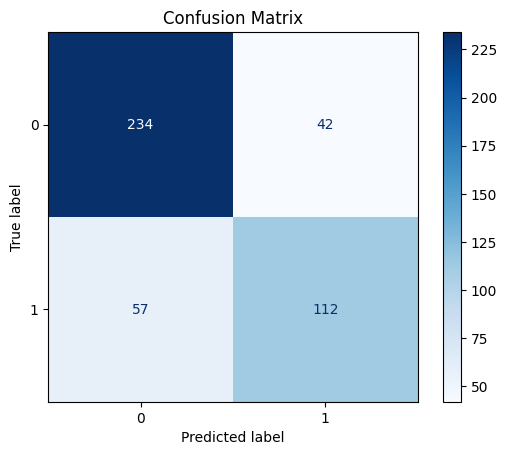

In [44]:
# Create accuracy score
print("accuracy: ", accuracy_score(y_true_5050_1500_4_64, y_pred_2_5050_1500_4_64))

# Create classification report
print(classification_report(y_true_5050_1500_4_64, y_pred_2_5050_1500_4_64))

# Create confusion matrix
cm = confusion_matrix(y_true_5050_1500_4_64, y_pred_2_5050_1500_4_64)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy:  0.8202247191011236
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       276
           1       0.80      0.70      0.75       169

    accuracy                           0.82       445
   macro avg       0.81      0.80      0.80       445
weighted avg       0.82      0.82      0.82       445



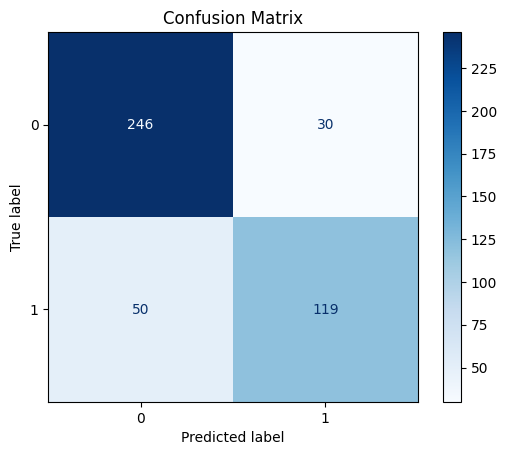

In [47]:
# Create accuracy score
print("accuracy: ", accuracy_score(y_true_3_5050_1500_32_64, y_pred_3_5050_1500_32_64))

# Create classification report
print(classification_report(y_true_3_5050_1500_32_64, y_pred_3_5050_1500_32_64))

# Create confusion matrix
cm = confusion_matrix(y_true_3_5050_1500_32_64, y_pred_3_5050_1500_32_64)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [53]:
y = []
y_true_3_7030_1500_32_64 = pd.read_csv('result/ensemble/y_true_7030_1500_32_64.csv')
y_pred_3_7030_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_7030_1500_32_64.csv', header=None)
y_true_3_6040_1500_32_64 = pd.read_csv('result/ensemble/y_true_6040_1500_32_64.csv')
y_pred_3_6040_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_6040_1500_32_64.csv', header=None)
y_true_3_5050_1500_32_64 = pd.read_csv('result/ensemble/y_true_5050_1500_32_64.csv')
y_pred_3_5050_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_5050_1500_32_64.csv', header=None)
y_true_3_4060_1500_32_64 = pd.read_csv('result/ensemble/y_true_4060_1500_32_64.csv')
y_pred_3_4060_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_4060_1500_32_64.csv', header=None)
y_true_3_3070_1500_32_64 = pd.read_csv('result/ensemble/y_true_3070_1500_32_64.csv')
y_pred_3_3070_1500_32_64 = pd.read_csv('result/ensemble/y_pred_3_3070_1500_32_64.csv', header=None)
y.append(accuracy_score(y_true_3_7030_1500_32_64, y_pred_3_7030_1500_32_64))
y.append(accuracy_score(y_true_3_6040_1500_32_64, y_pred_3_6040_1500_32_64))
y.append(accuracy_score(y_true_3_5050_1500_32_64, y_pred_3_5050_1500_32_64))
y.append(accuracy_score(y_true_3_4060_1500_32_64, y_pred_3_4060_1500_32_64))
y.append(accuracy_score(y_true_3_3070_1500_32_64, y_pred_3_3070_1500_32_64))
x = ['70:30', '60:40', '50:50', '40:60', '30:70']

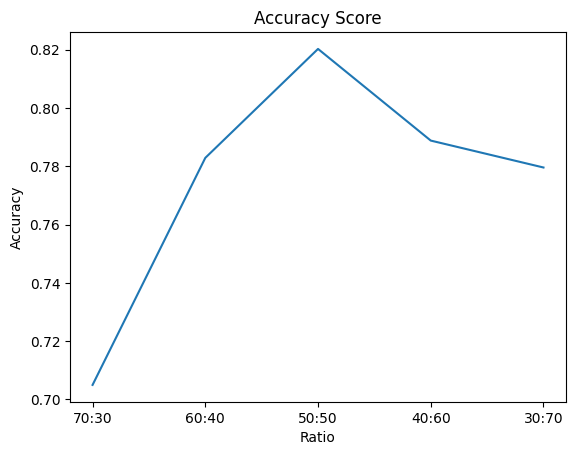

In [54]:
plt.title('Accuracy Score')
plt.xlabel('Ratio')
plt.ylabel('Accuracy')
plt.plot(x, y)